### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages.csv', parse_dates=['Start', 'Finish', 'file_name'])

# removed unplanned
df = df[df['Unplanned?'] != 1]
# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]

### Create bins for the output for classification 

In [3]:
# Compute quantiles from 0.0 to 1.0 in 0.1 steps
quantiles = df['Duration_Hours'].quantile(np.arange(0, 1.1, 0.1))

# Drop duplicate bin edges to avoid pd.cut() error
bins = np.unique(quantiles.values)

# Create readable labels
labels = [f"{round(bins[i], 1)}–{round(bins[i+1], 1)} hrs" for i in range(len(bins) - 1)]

# Bin the data
df['Duration_Category'] = pd.cut(df['Duration_Hours'], bins=bins, labels=labels, include_lowest=True)

# Check the bin distribution
print(df['Duration_Category'].value_counts().sort_index())

Duration_Category
0.2–6.5 hrs        248
6.5–9.0 hrs        300
9.0–10.0 hrs       457
10.0–11.0 hrs      179
11.0–12.0 hrs      443
12.0–12.5 hrs       58
12.5–55.2 hrs      201
55.2–132.0 hrs     217
132.0–921.6 hrs    227
Name: count, dtype: int64


### Random forest classification

In [4]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd


def train_with_cross_validation(df, n_folds=5, random_state=42):
    """
    Implement k-fold cross-validation on the RandomForest classification model.
    
    Args:
        df: Pandas DataFrame with features and target
        n_folds: Number of folds for cross-validation
        random_state: Random seed for reproducibility
        
    Returns:
        Trained model on the full dataset and cross-validation results
    """
    
    # --- 1. Select Features and Target (same as original)
    features = ['Recall_Day_Hours', 'Recall_Night_Hours',  # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',  # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description'  # categorical columns
                ] 
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]
    
    # --- 2. Encode Categorical Features (same as original)
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])
    
    # --- 3. Define model
    model = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    
    # --- 4. Set up k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # --- 5. Define metrics to track
    scoring = {
        'accuracy': 'accuracy',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted',
        'f1_weighted': 'f1_weighted'
    }
    
    # --- 6. Perform cross-validation
    cv_results = cross_validate(
        model, X, y, 
        cv=kf, 
        scoring=scoring,
        return_train_score=True,
        return_estimator=True  # This will return the models trained in each fold
    )
    
    # --- 7. Display cross-validation results
    print(f"Cross-Validation Results ({n_folds}-fold):")
    print(f"Test Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"Test Precision: {cv_results['test_precision_weighted'].mean():.4f} ± {cv_results['test_precision_weighted'].std():.4f}")
    print(f"Test Recall: {cv_results['test_recall_weighted'].mean():.4f} ± {cv_results['test_recall_weighted'].std():.4f}")
    print(f"Test F1: {cv_results['test_f1_weighted'].mean():.4f} ± {cv_results['test_f1_weighted'].std():.4f}")
    
    # --- 8. Visualize cross-validation results
    visualize_cv_results(cv_results)
    
    # --- 9. Train final model on the full dataset
    final_model = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    final_model.fit(X, y)
    
    # --- 10. Display feature importances
    visualize_feature_importances(final_model, X.columns)
    
    return final_model, cv_results


def visualize_cv_results(cv_results):
    """Visualize cross-validation metrics comparison and distribution."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot train vs test metrics
    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    train_means = [cv_results[f'train_{m}'].mean() for m in metrics]
    test_means = [cv_results[f'test_{m}'].mean() for m in metrics]
    train_stds = [cv_results[f'train_{m}'].std() for m in metrics]
    test_stds = [cv_results[f'test_{m}'].std() for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax1.bar(x - width/2, train_means, width, label='Train', color='darkcyan', yerr=train_stds)
    ax1.bar(x + width/2, test_means, width, label='Test', color='slateblue', yerr=test_stds)
    
    ax1.set_title('Cross-Validation Metrics')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.replace('_weighted', '').capitalize() for m in metrics])
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    # Plot distribution of test accuracy across folds
    fold_numbers = range(1, len(cv_results['test_accuracy']) + 1)
    ax2.plot(fold_numbers, cv_results['test_accuracy'], 'o-', label='Accuracy', color='green')
    ax2.plot(fold_numbers, cv_results['test_f1_weighted'], 's-', label='F1', color='orange')
    ax2.axhline(cv_results['test_accuracy'].mean(), linestyle='--', color='darkgreen', alpha=0.7)
    ax2.axhline(cv_results['test_f1_weighted'].mean(), linestyle='--', color='darkorange', alpha=0.7)
    
    ax2.set_title('Metrics by Fold')
    ax2.set_xlabel('Fold')
    ax2.set_xticks(fold_numbers)
    ax2.set_ylim([0, 1])
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def visualize_feature_importances(model, feature_names):
    """Visualize feature importances from the trained model."""
    plt.figure(figsize=(10, 6))
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
    plt.xlabel('Importance')
    plt.title('Feature Importances (Full Dataset Model)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def detailed_fold_analysis(df, n_folds=5, random_state=42):
    """
    Perform detailed analysis of each fold in cross-validation, 
    including confusion matrices for each fold.
    """
    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours',
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]
    
    # --- 2. Encode categorical features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])
    
    # --- 3. Set up k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Get unique labels (duration categories)
    labels = sorted(y.unique())
    
    # --- 4. Process each fold
    fold_results = []
    
    fig = plt.figure(figsize=(18, 4 * n_folds))
    gs = gridspec.GridSpec(n_folds, 2)
    
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model for this fold
        fold_model = RandomForestClassifier(random_state=random_state, class_weight='balanced')
        fold_model.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = fold_model.predict(X_train)
        y_test_pred = fold_model.predict(X_test)
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        # Store results
        fold_results.append({
            'fold': i + 1,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'test_precision': precision_score(y_test, y_test_pred, average='weighted'),
            'test_recall': recall_score(y_test, y_test_pred, average='weighted'),
            'test_f1': f1_score(y_test, y_test_pred, average='weighted')
        })
        
        # Plot confusion matrices
        # Get present labels (classes that actually exist in this fold)
        present_labels = [label for label in labels if label in y_test.unique()]
        
        # Train confusion matrix
        ax1 = fig.add_subplot(gs[i, 0])
        cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
        disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
        disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
        ax1.set_title(f"Fold {i+1}: Train Confusion Matrix\n(Acc: {train_acc:.2%})")
        
        # Test confusion matrix
        ax2 = fig.add_subplot(gs[i, 1])
        cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)
        disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
        disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
        ax2.set_title(f"Fold {i+1}: Test Confusion Matrix\n(Acc: {test_acc:.2%})")
    
    plt.tight_layout()
    plt.show()
    
    # Print fold results as a table
    fold_df = pd.DataFrame(fold_results)
    print("\nDetailed Results by Fold:")
    print(fold_df.round(4))
    print("\nAverage Metrics:")
    print(fold_df[['test_acc', 'test_precision', 'test_recall', 'test_f1']].mean().round(4))
    
    return fold_df


# Example usage:
# Assuming 'df' contains your dataset with features and 'Duration_Category' column
# 
# # Basic cross-validation
# final_model, cv_results = train_with_cross_validation(df, n_folds=5)
#
# # Detailed fold-by-fold analysis
# fold_results = detailed_fold_analysis(df, n_folds=5)

Cross-Validation Results (5-fold):
Test Accuracy: 0.5597 ± 0.0118
Test Precision: 0.6466 ± 0.0146
Test Recall: 0.5597 ± 0.0118
Test F1: 0.5849 ± 0.0124


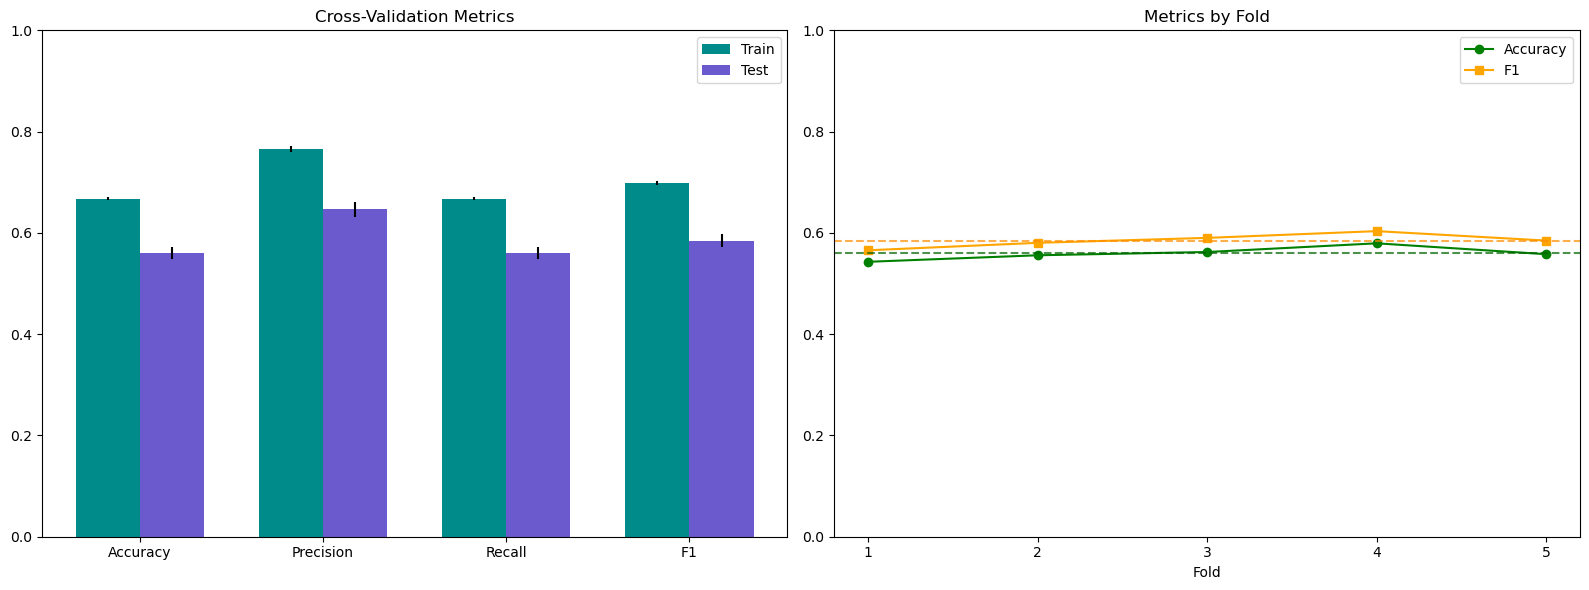

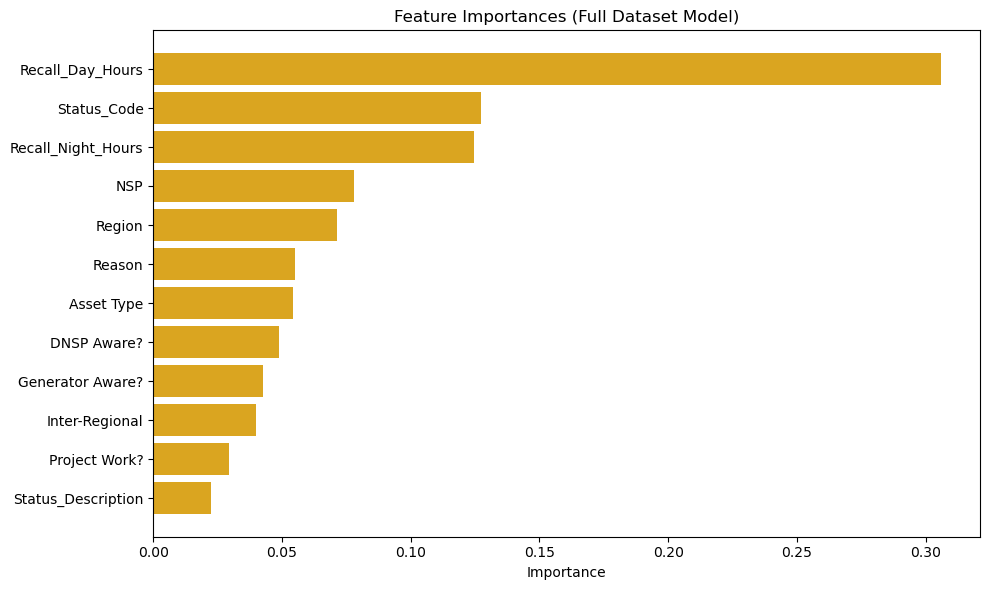

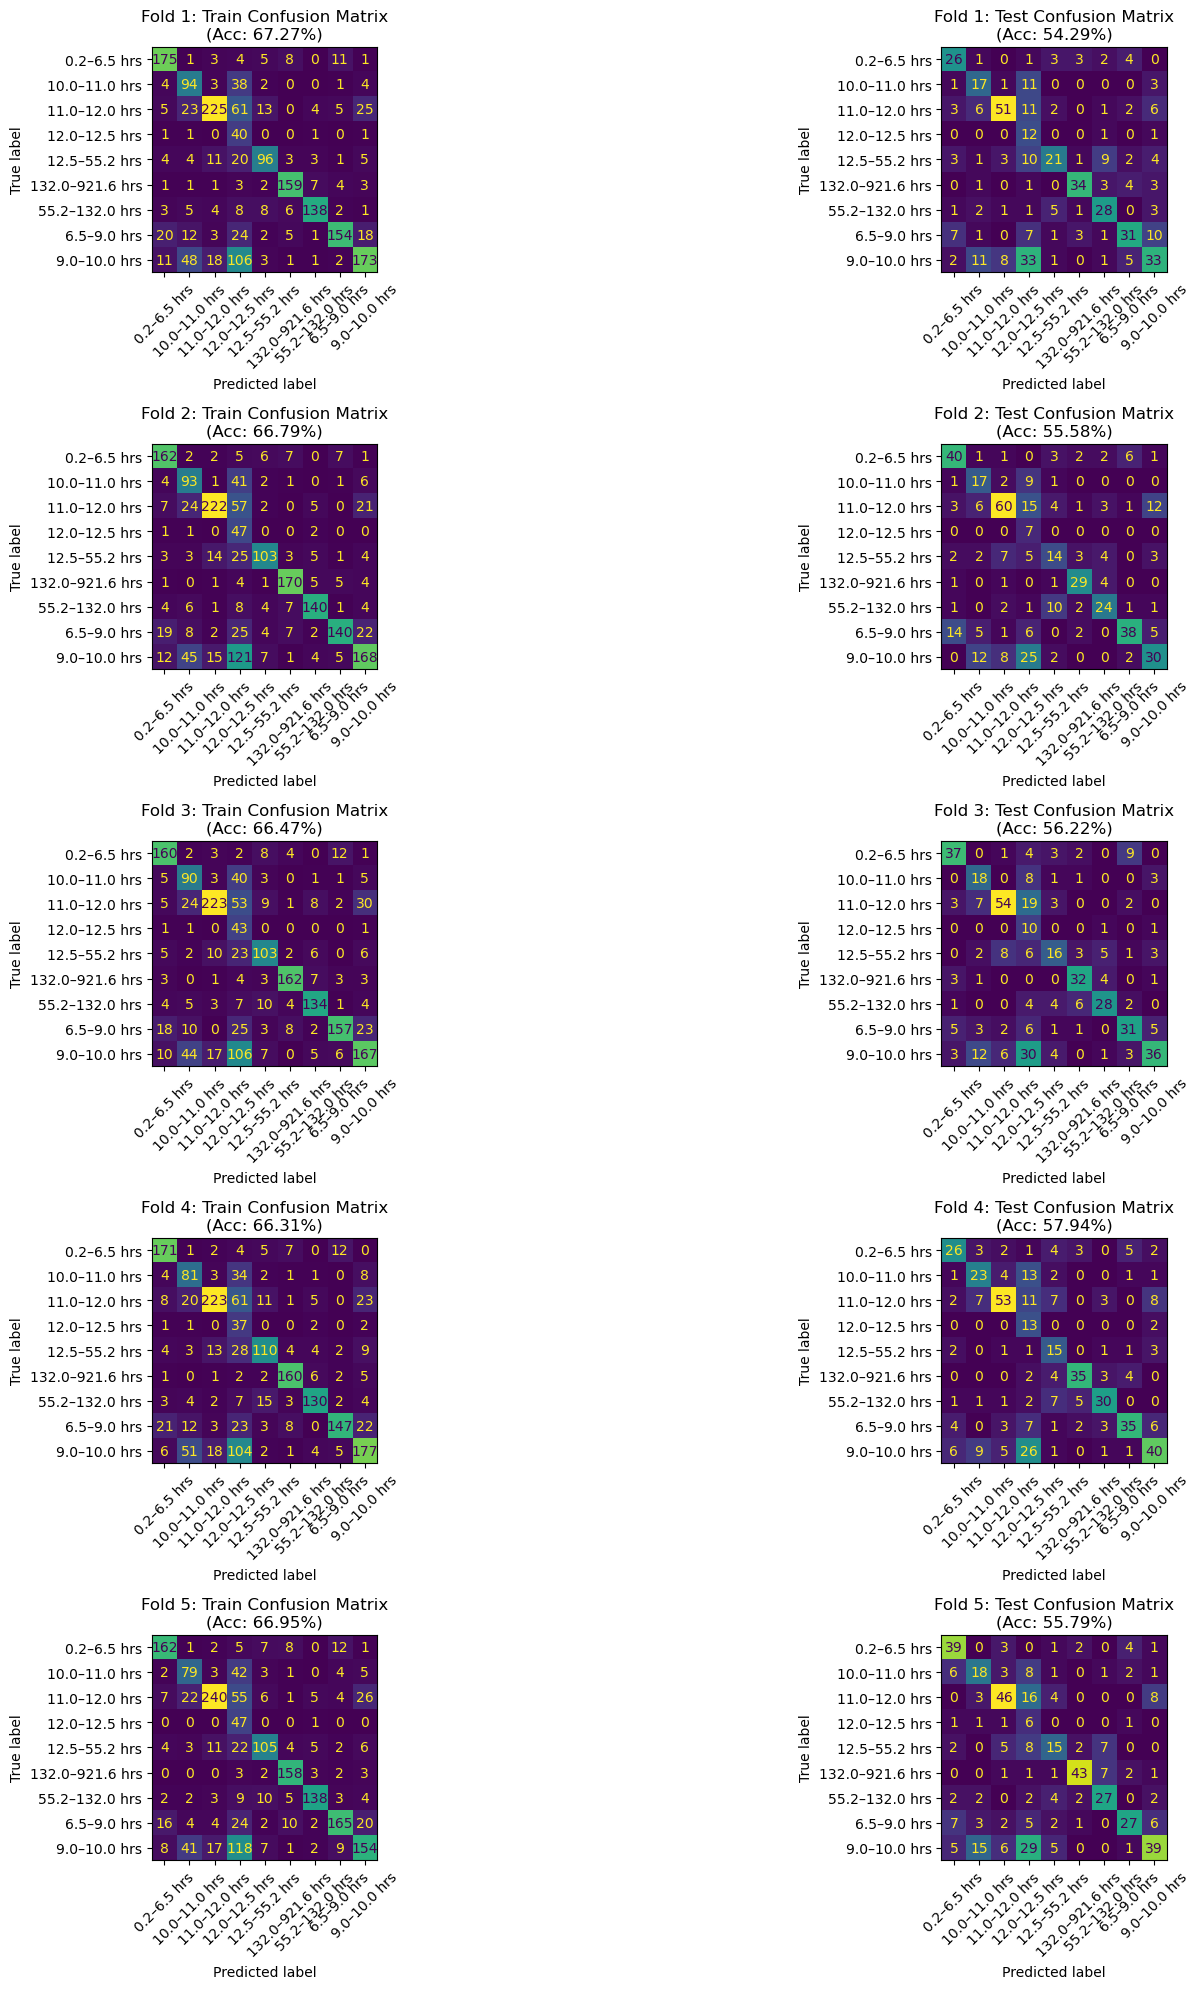


Detailed Results by Fold:
   fold  train_acc  test_acc  test_precision  test_recall  test_f1
0     1     0.6727    0.5429          0.6251       0.5429   0.5657
1     2     0.6679    0.5558          0.6381       0.5558   0.5804
2     3     0.6647    0.5622          0.6637       0.5622   0.5902
3     4     0.6631    0.5794          0.6617       0.5794   0.6035
4     5     0.6695    0.5579          0.6447       0.5579   0.5848

Average Metrics:
test_acc          0.5597
test_precision    0.6466
test_recall       0.5597
test_f1           0.5849
dtype: float64


In [6]:
final_model, cv_results = train_with_cross_validation(df, n_folds=5)
fold_results = detailed_fold_analysis(df, n_folds=5)


--- REGION: SA (n=286 samples) ---

Running cross-validation for region 'SA':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Results (5-fold):
Test Accuracy: 0.6402 ± 0.0782
Test Precision: 0.6644 ± 0.0848
Test Recall: 0.6402 ± 0.0782
Test F1: 0.6409 ± 0.0829


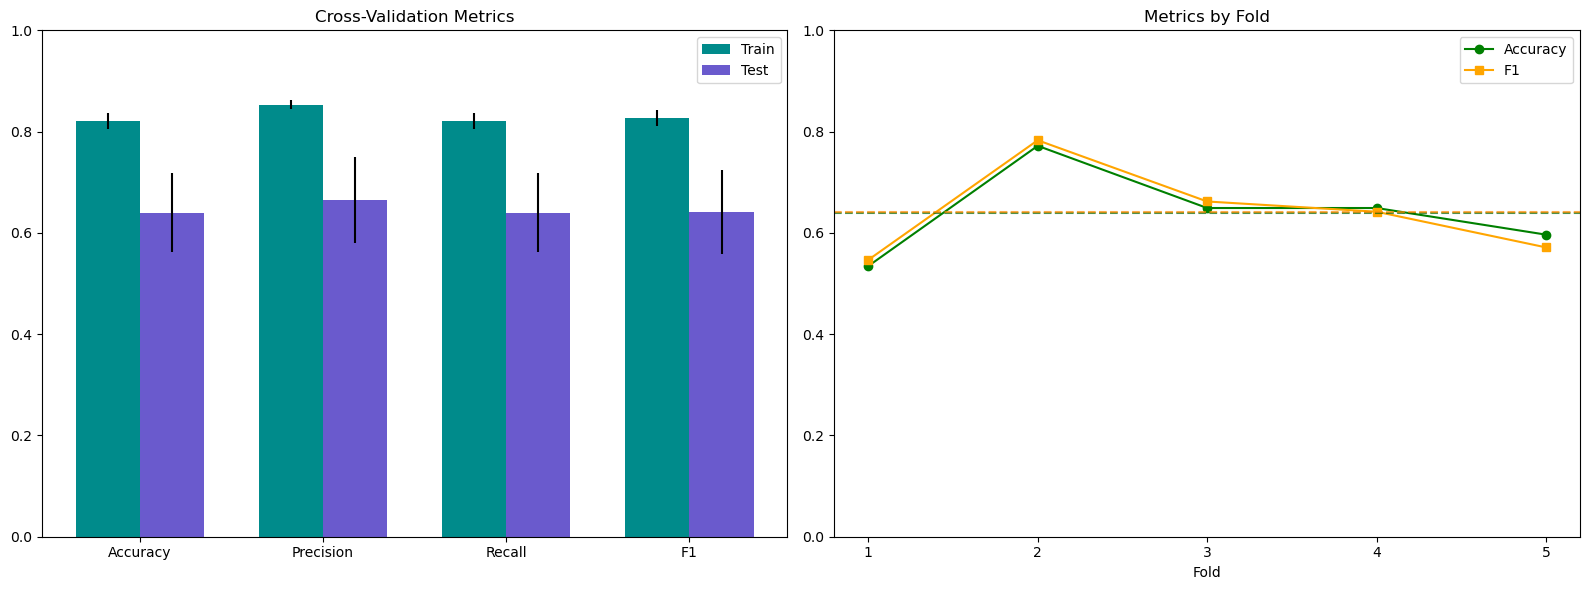

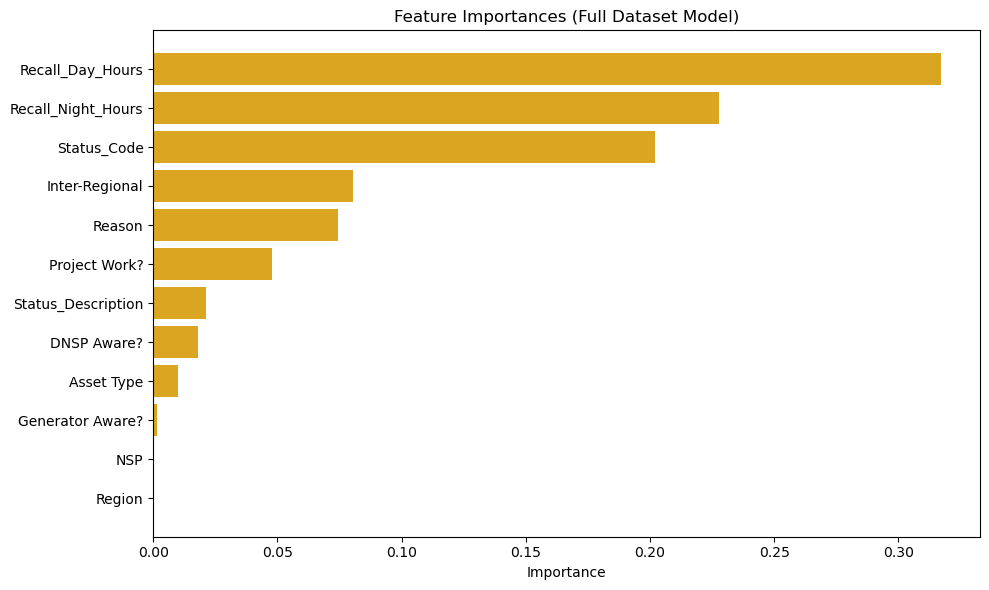


Detailed fold analysis for region 'SA':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


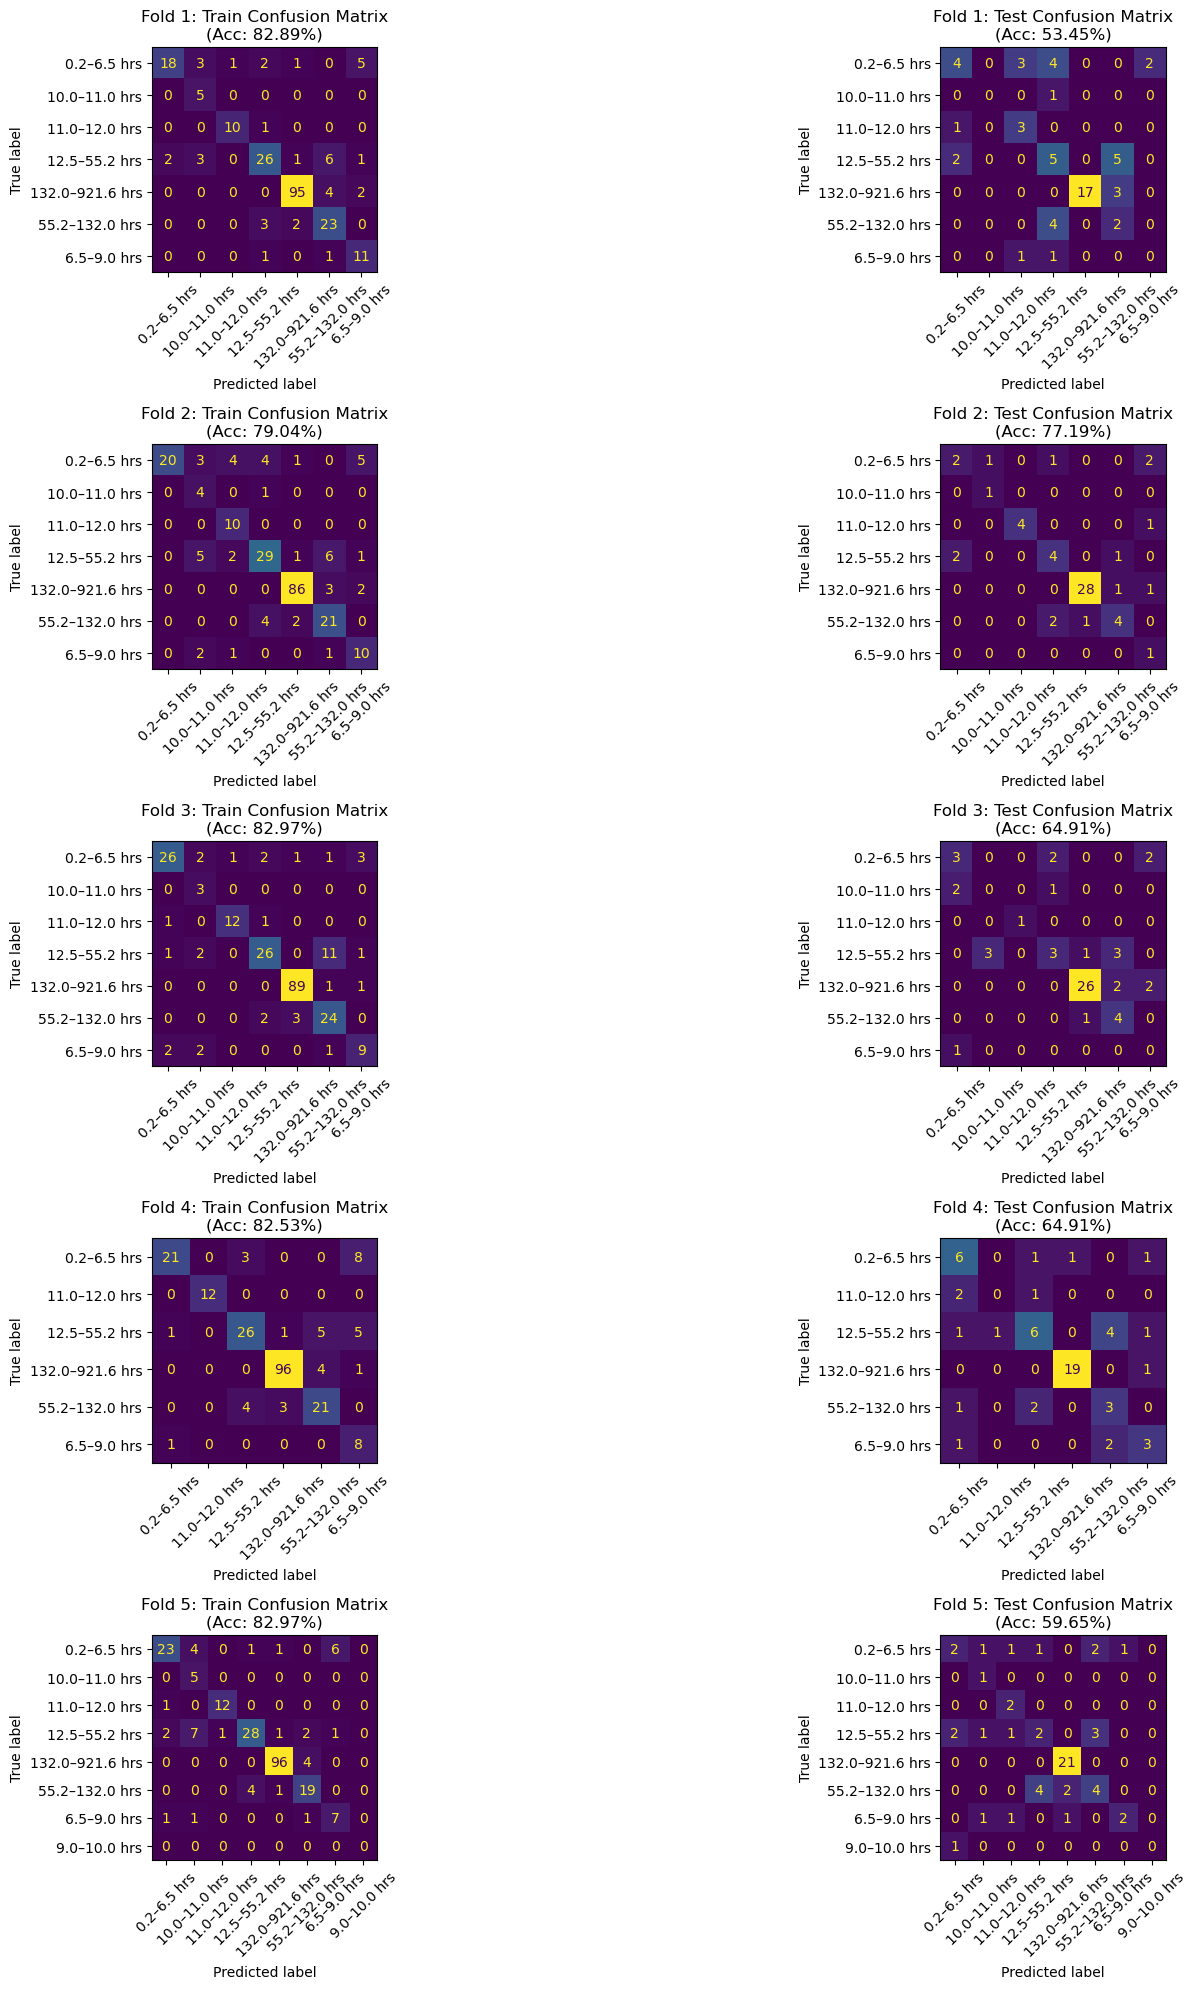


Detailed Results by Fold:
   fold  train_acc  test_acc  test_precision  test_recall  test_f1
0     1     0.8289    0.5345          0.5921       0.5345   0.5466
1     2     0.7904    0.7719          0.8128       0.7719   0.7829
2     3     0.8297    0.6491          0.6944       0.6491   0.6620
3     4     0.8253    0.6491          0.6440       0.6491   0.6418
4     5     0.8297    0.5965          0.5785       0.5965   0.5713

Average Metrics:
test_acc          0.6402
test_precision    0.6644
test_recall       0.6402
test_f1           0.6409
dtype: float64

Completed analysis for region 'SA'

--- REGION: VIC (n=1251 samples) ---

Running cross-validation for region 'VIC':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Results (5-fold):
Test Accuracy: 0.3677 ± 0.0251
Test Precision: 0.5619 ± 0.0234
Test Recall: 0.3677 ± 0.0251
Test F1: 0.3809 ± 0.0361


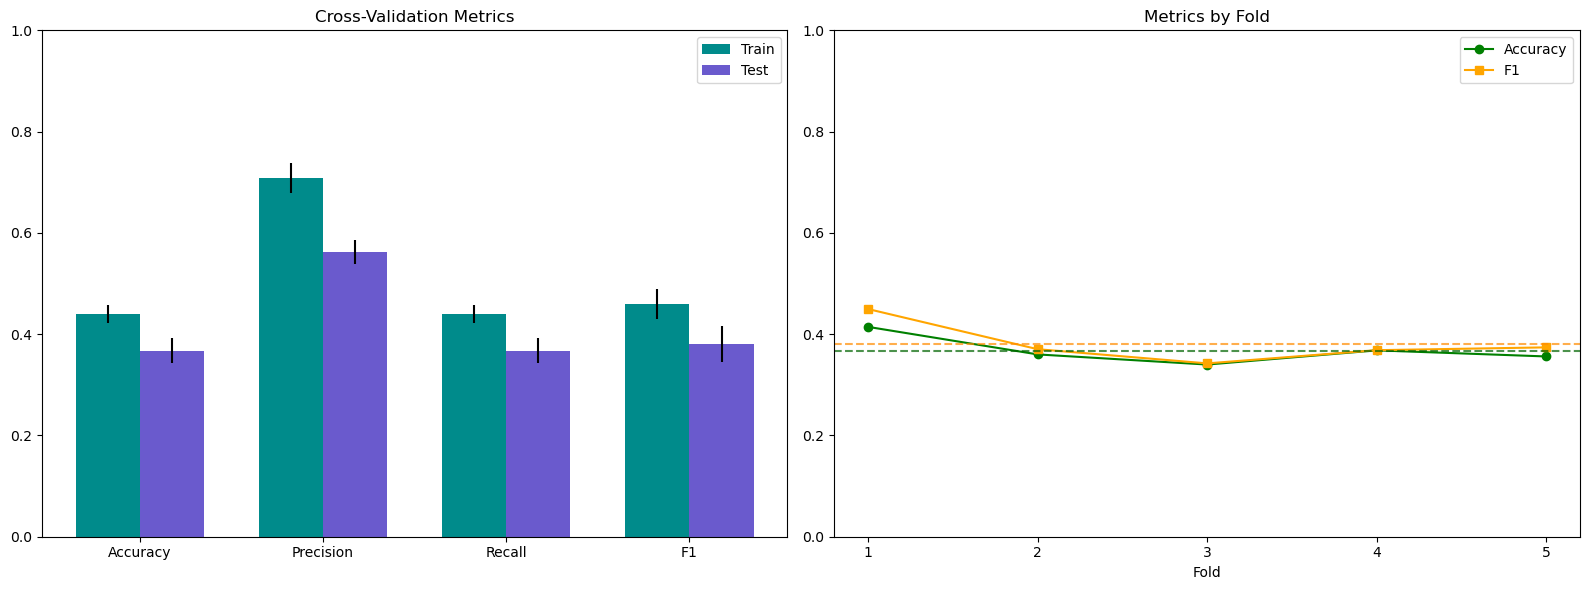

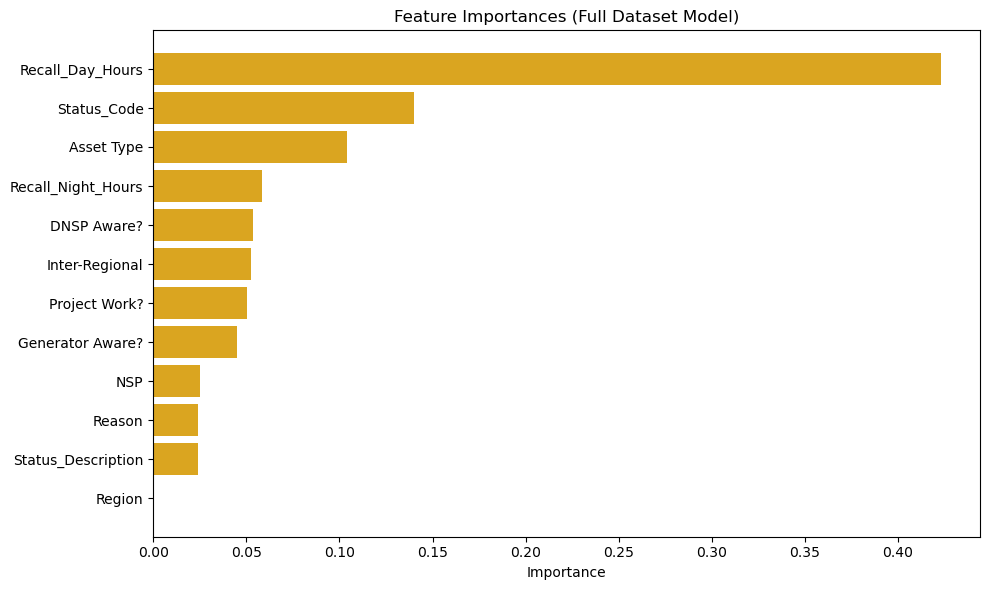


Detailed fold analysis for region 'VIC':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


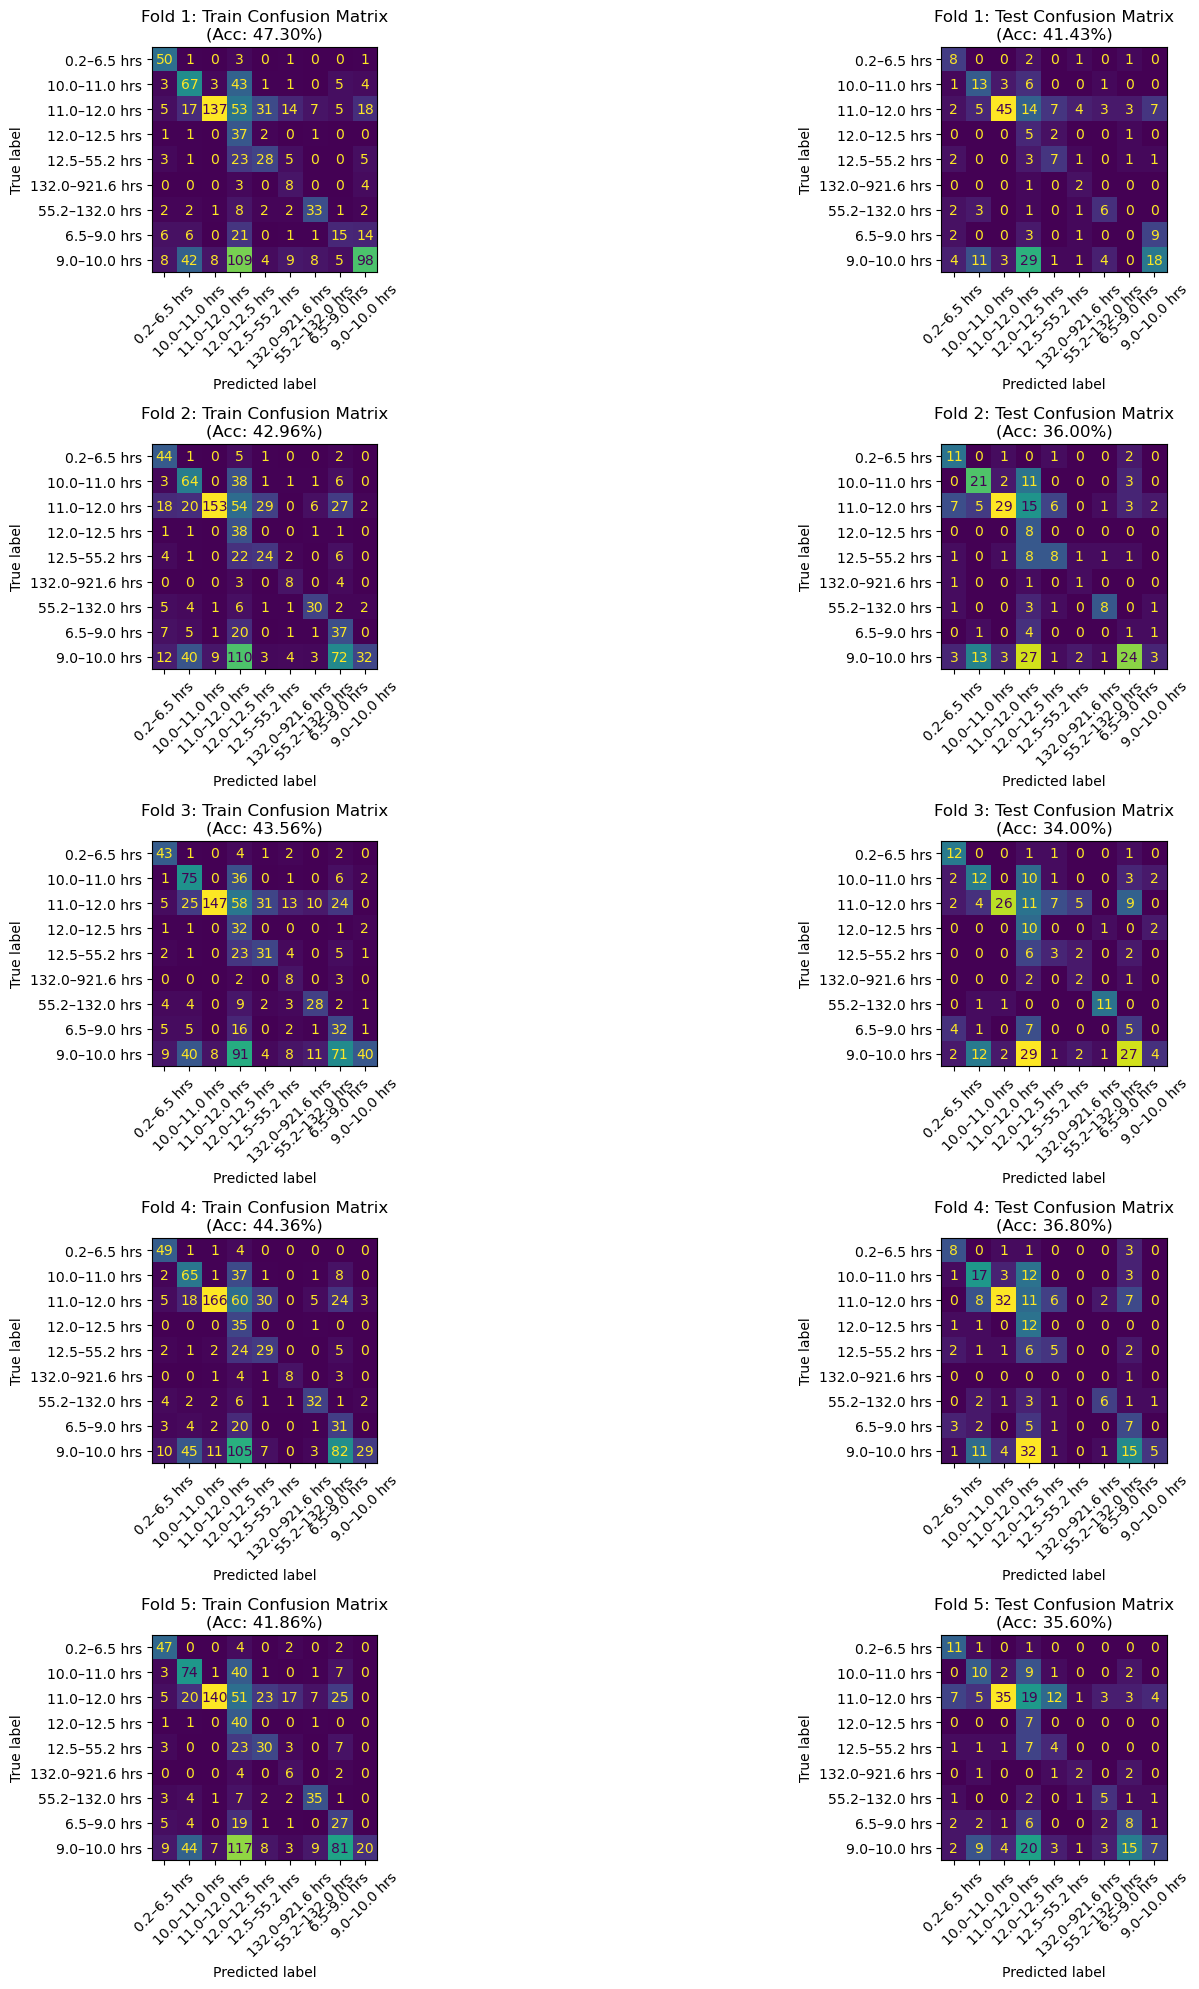


Detailed Results by Fold:
   fold  train_acc  test_acc  test_precision  test_recall  test_f1
0     1     0.4730    0.4143          0.5704       0.4143   0.4495
1     2     0.4296    0.3600          0.5437       0.3600   0.3703
2     3     0.4356    0.3400          0.5438       0.3400   0.3423
3     4     0.4436    0.3680          0.6042       0.3680   0.3684
4     5     0.4186    0.3560          0.5472       0.3560   0.3739

Average Metrics:
test_acc          0.3677
test_precision    0.5619
test_recall       0.3677
test_f1           0.3809
dtype: float64

Completed analysis for region 'VIC'

--- REGION: TAS (n=145 samples) ---

Running cross-validation for region 'TAS':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklea

Cross-Validation Results (5-fold):
Test Accuracy: 0.6897 ± 0.0218
Test Precision: 0.7309 ± 0.0662
Test Recall: 0.6897 ± 0.0218
Test F1: 0.6831 ± 0.0348


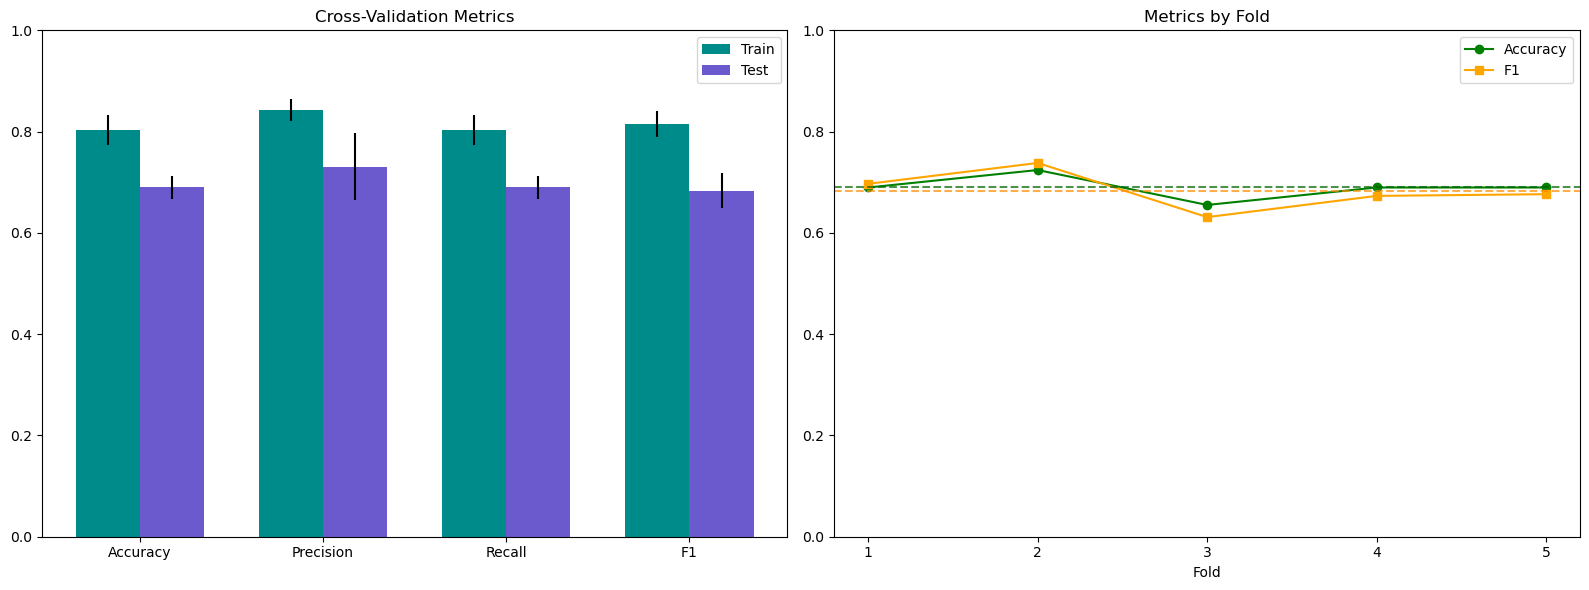

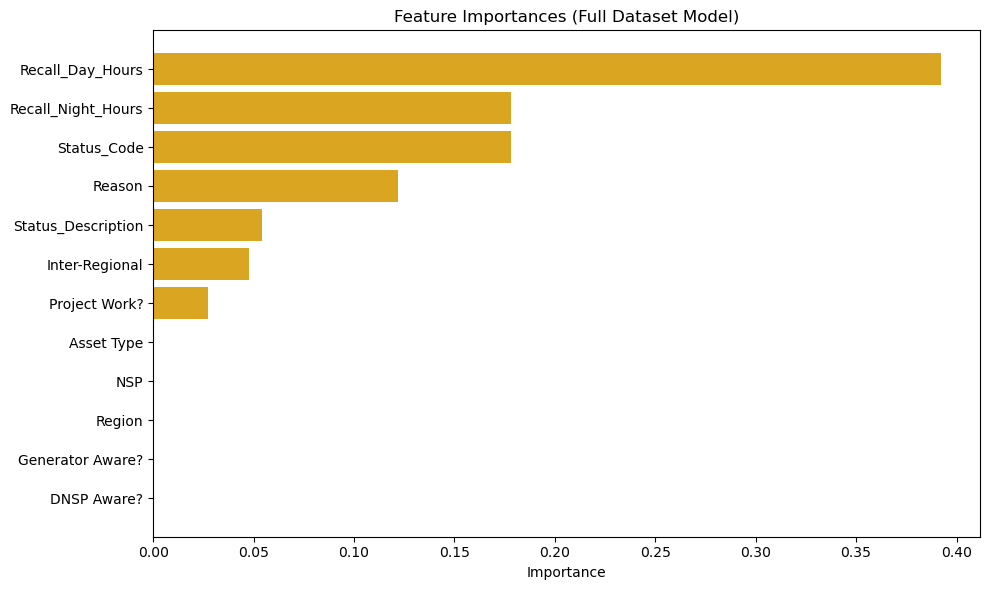


Detailed fold analysis for region 'TAS':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklea

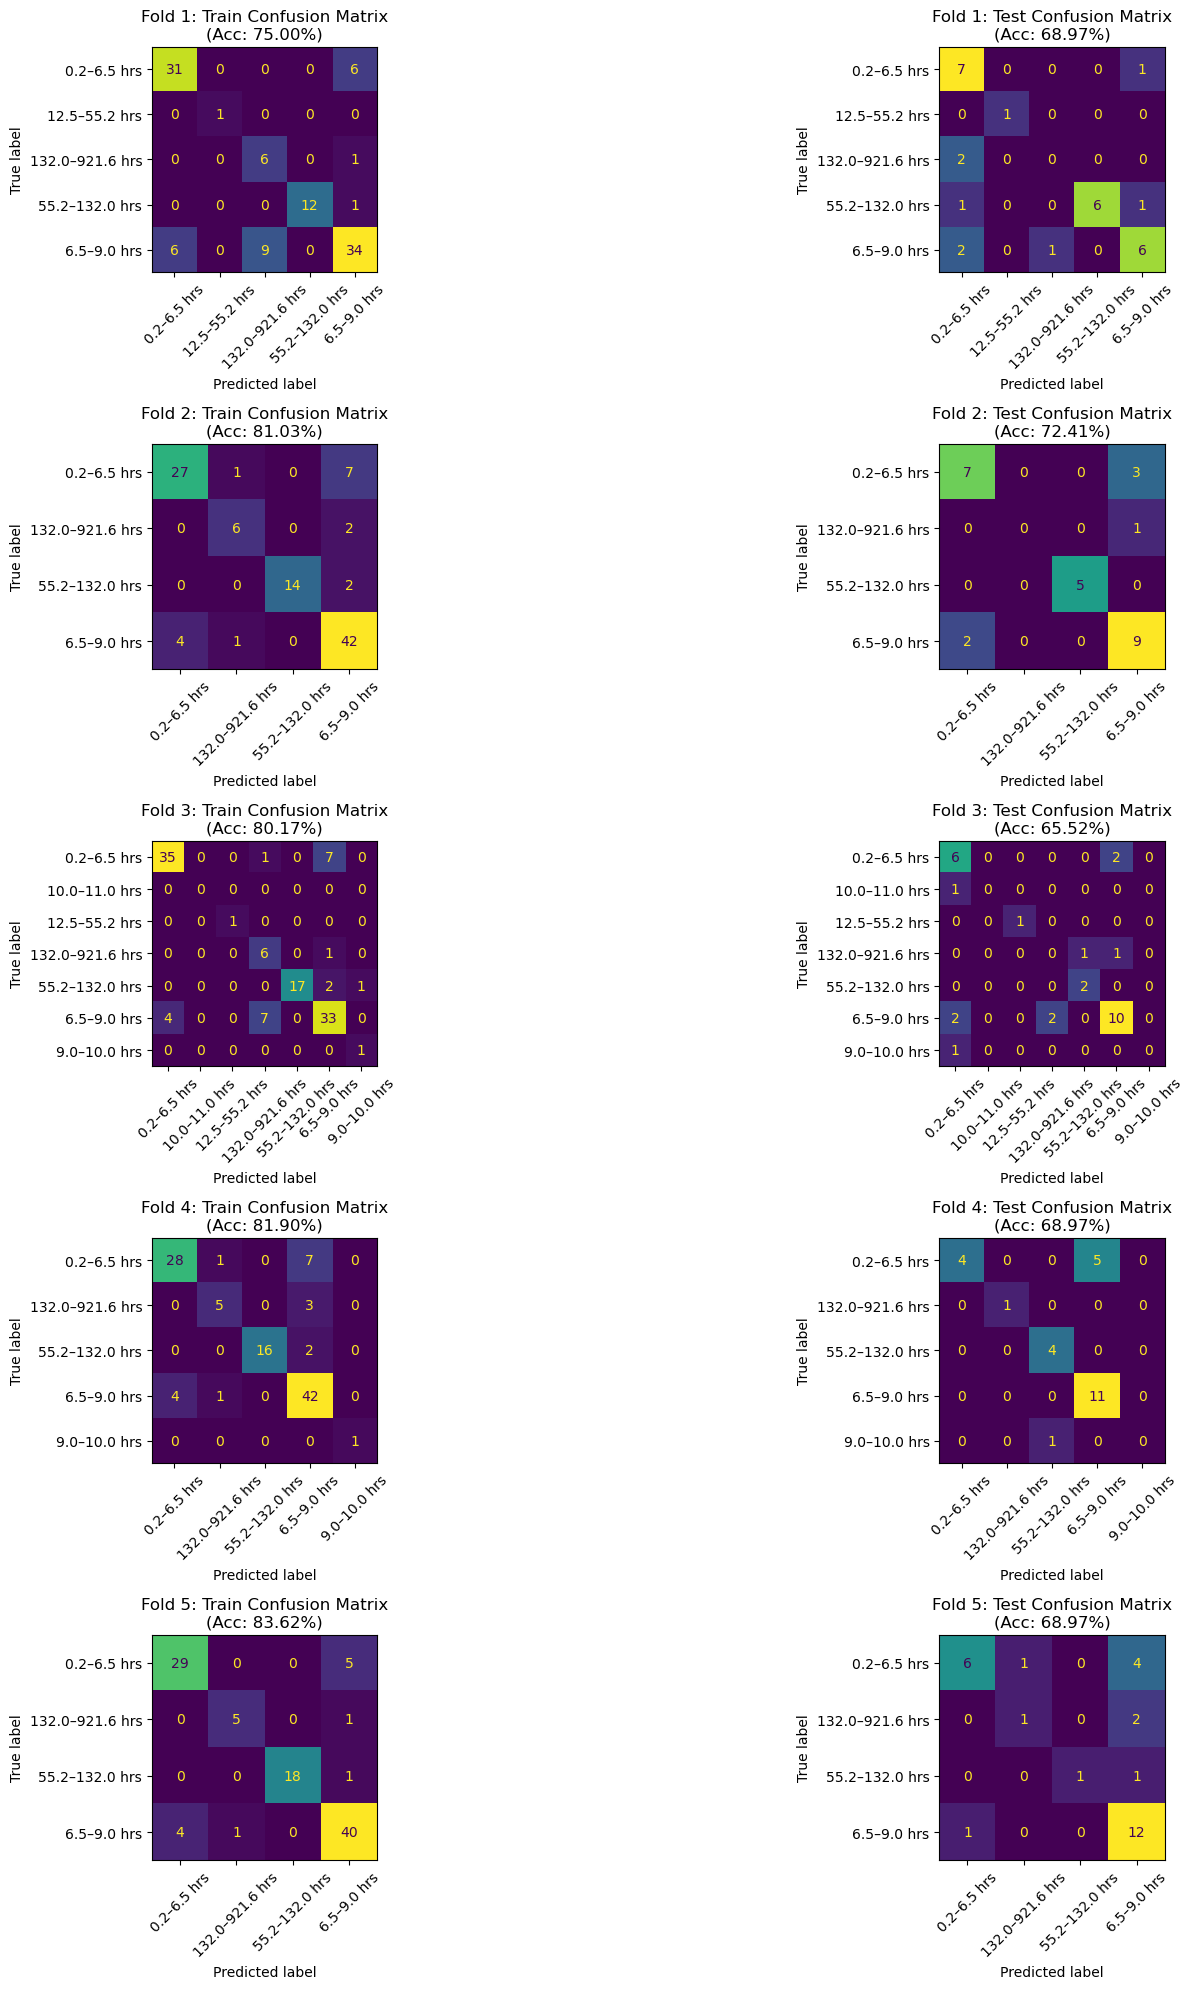


Detailed Results by Fold:
   fold  train_acc  test_acc  test_precision  test_recall  test_f1
0     1     0.7500    0.6897          0.7241       0.6897   0.6969
1     2     0.8103    0.7241          0.7645       0.7241   0.7381
2     3     0.8017    0.6552          0.6173       0.6552   0.6312
3     4     0.8190    0.6897          0.8194       0.6897   0.6731
4     5     0.8362    0.6897          0.7289       0.6897   0.6764

Average Metrics:
test_acc          0.6897
test_precision    0.7309
test_recall       0.6897
test_f1           0.6831
dtype: float64

Completed analysis for region 'TAS'

--- REGION: QLD (n=376 samples) ---

Running cross-validation for region 'QLD':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklea

Cross-Validation Results (5-fold):
Test Accuracy: 0.6329 ± 0.0406
Test Precision: 0.6882 ± 0.0253
Test Recall: 0.6329 ± 0.0406
Test F1: 0.6414 ± 0.0415


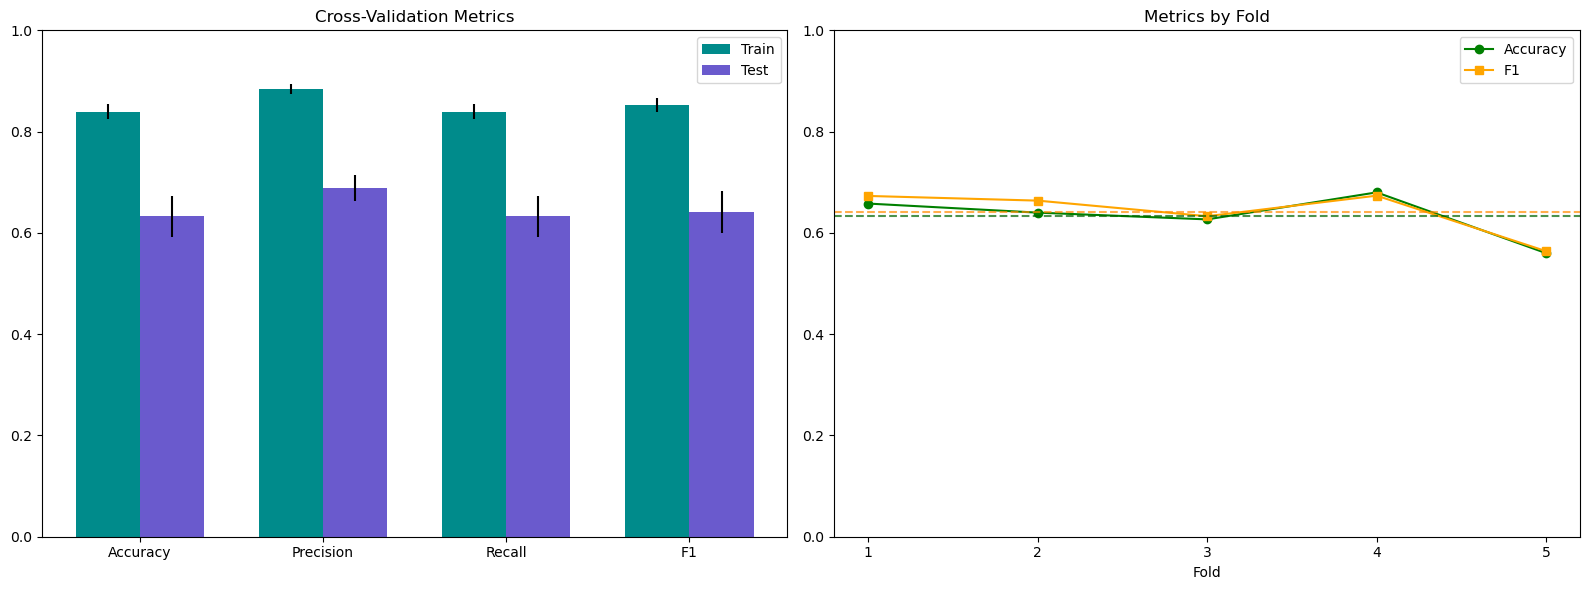

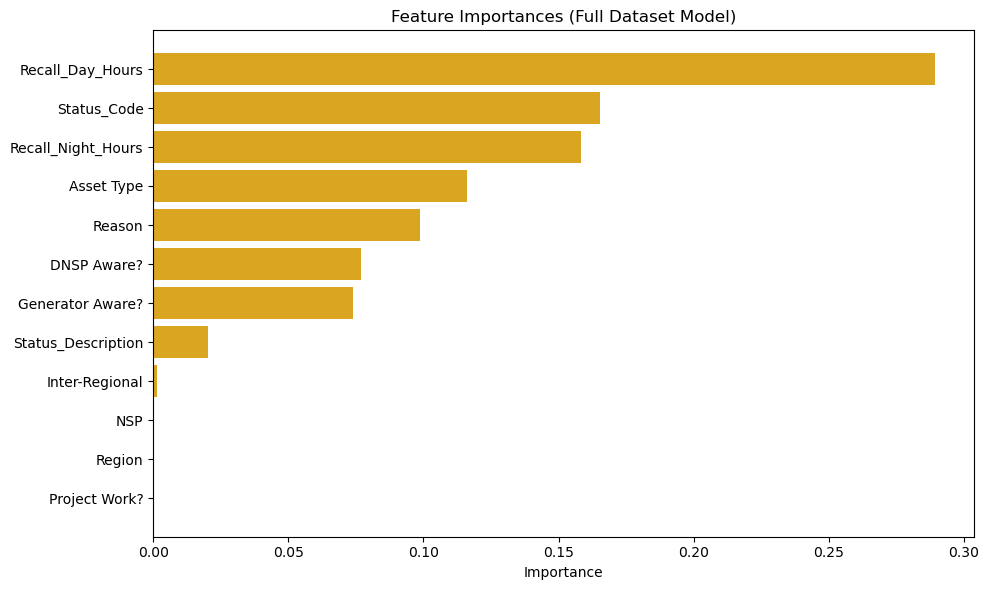


Detailed fold analysis for region 'QLD':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklea

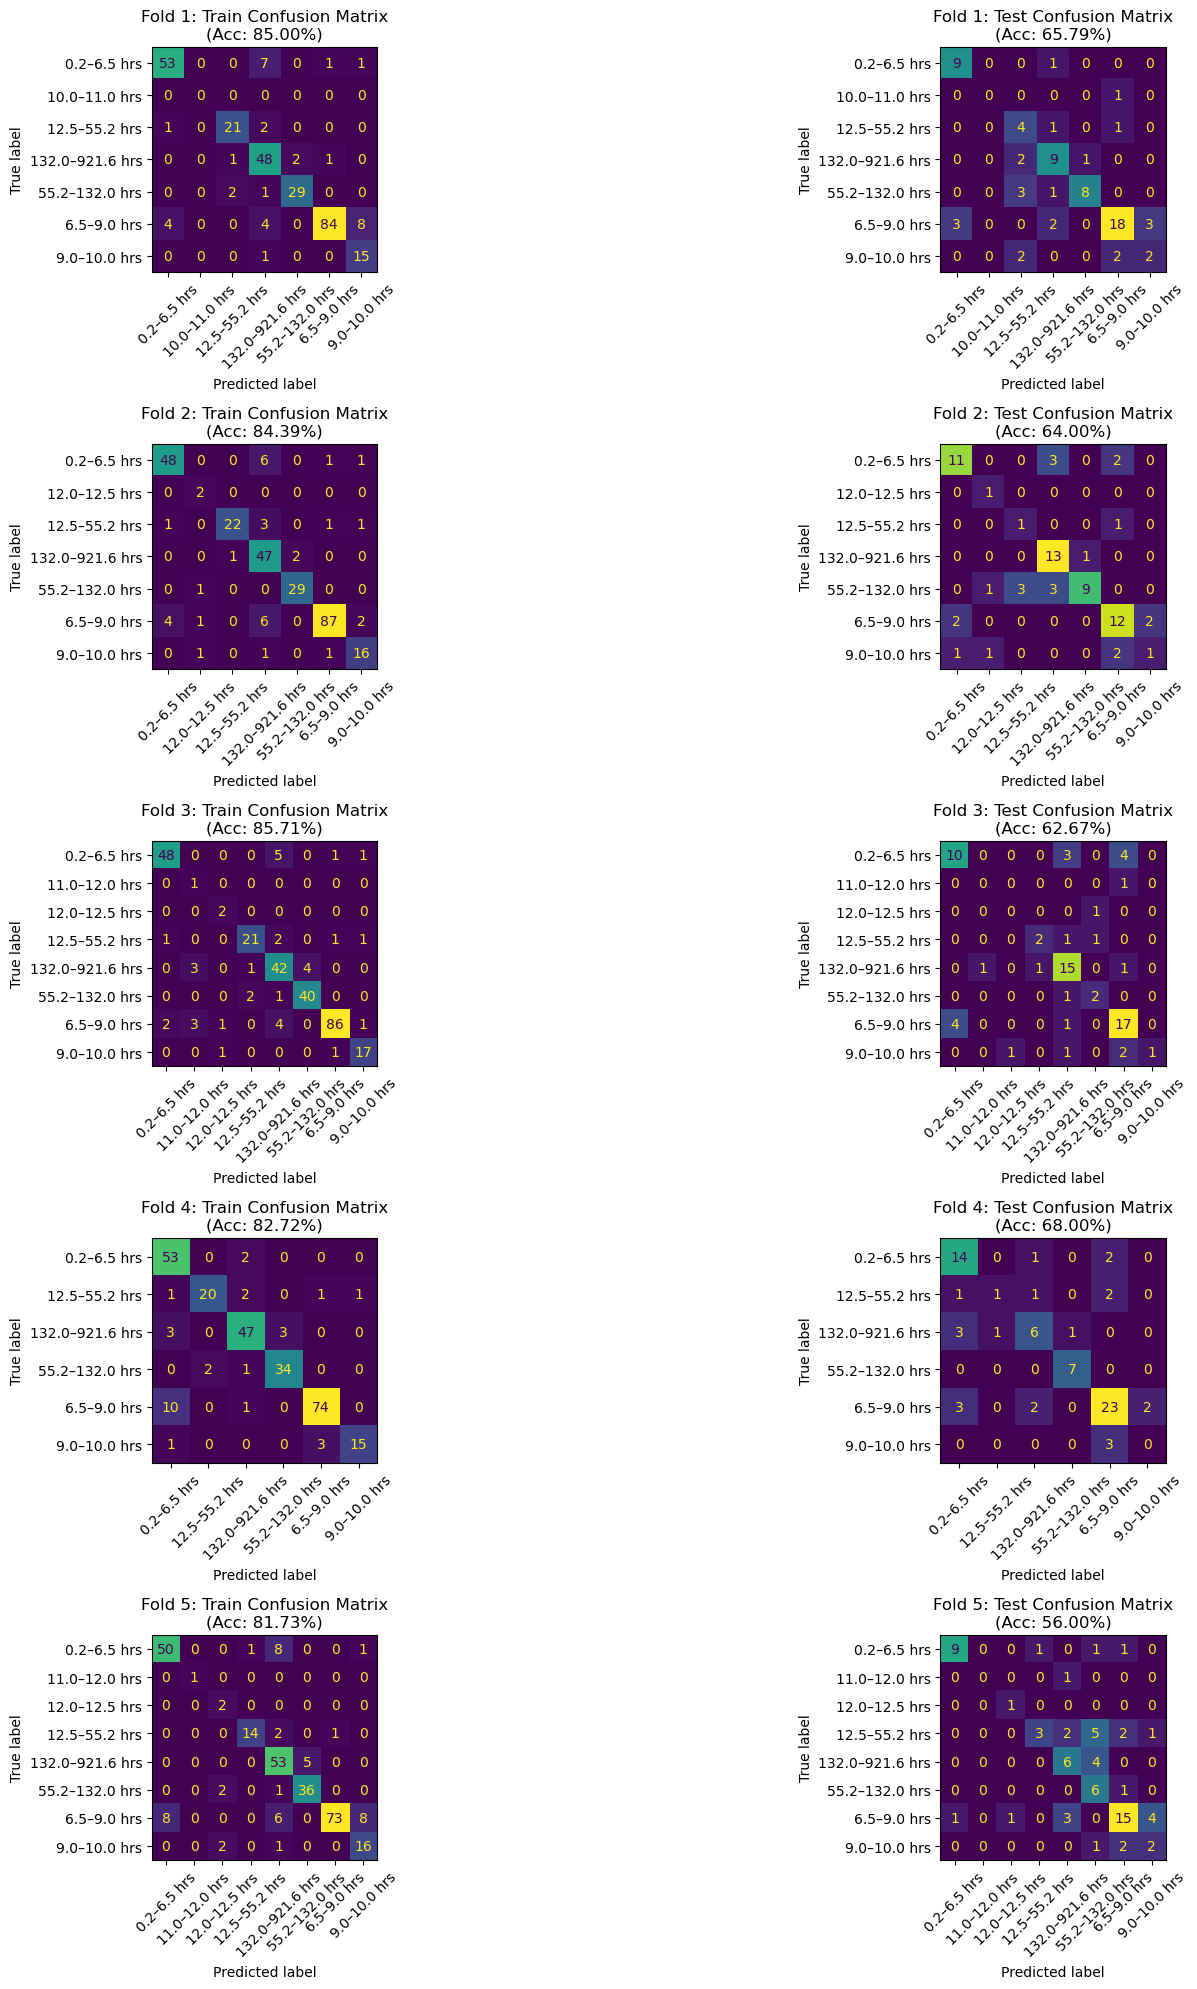


Detailed Results by Fold:
   fold  train_acc  test_acc  test_precision  test_recall  test_f1
0     1     0.8500    0.6579          0.7117       0.6579   0.6730
1     2     0.8439    0.6400          0.7177       0.6400   0.6637
2     3     0.8571    0.6267          0.6835       0.6267   0.6329
3     4     0.8272    0.6800          0.6812       0.6800   0.6735
4     5     0.8173    0.5600          0.6469       0.5600   0.5639

Average Metrics:
test_acc          0.6329
test_precision    0.6882
test_recall       0.6329
test_f1           0.6414
dtype: float64

Completed analysis for region 'QLD'

--- REGION: NSW (n=272 samples) ---

Running cross-validation for region 'NSW':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Results (5-fold):
Test Accuracy: 0.5699 ± 0.0311
Test Precision: 0.6302 ± 0.0515
Test Recall: 0.5699 ± 0.0311
Test F1: 0.5785 ± 0.0384


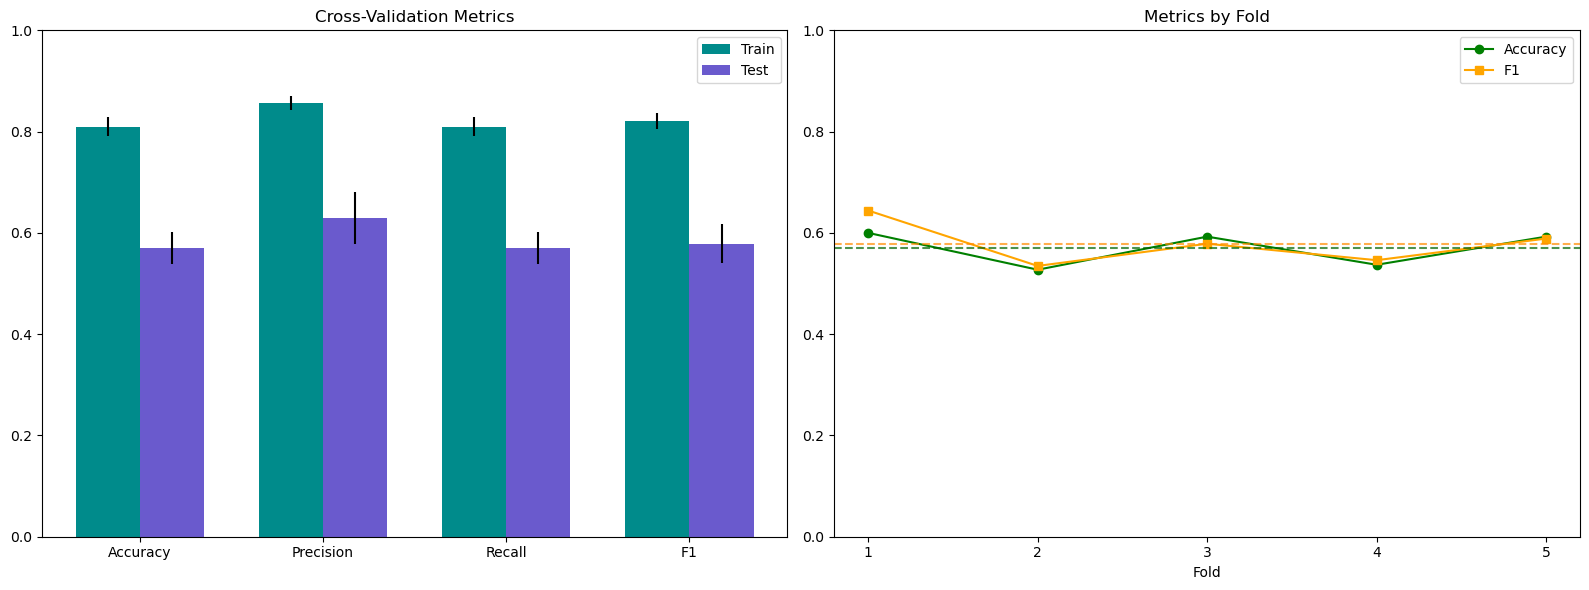

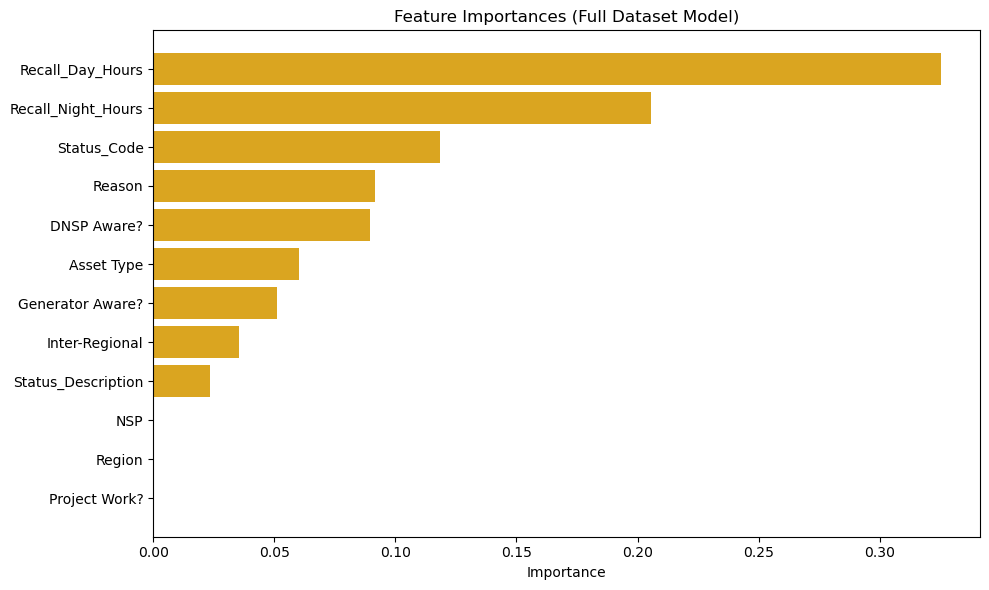


Detailed fold analysis for region 'NSW':


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


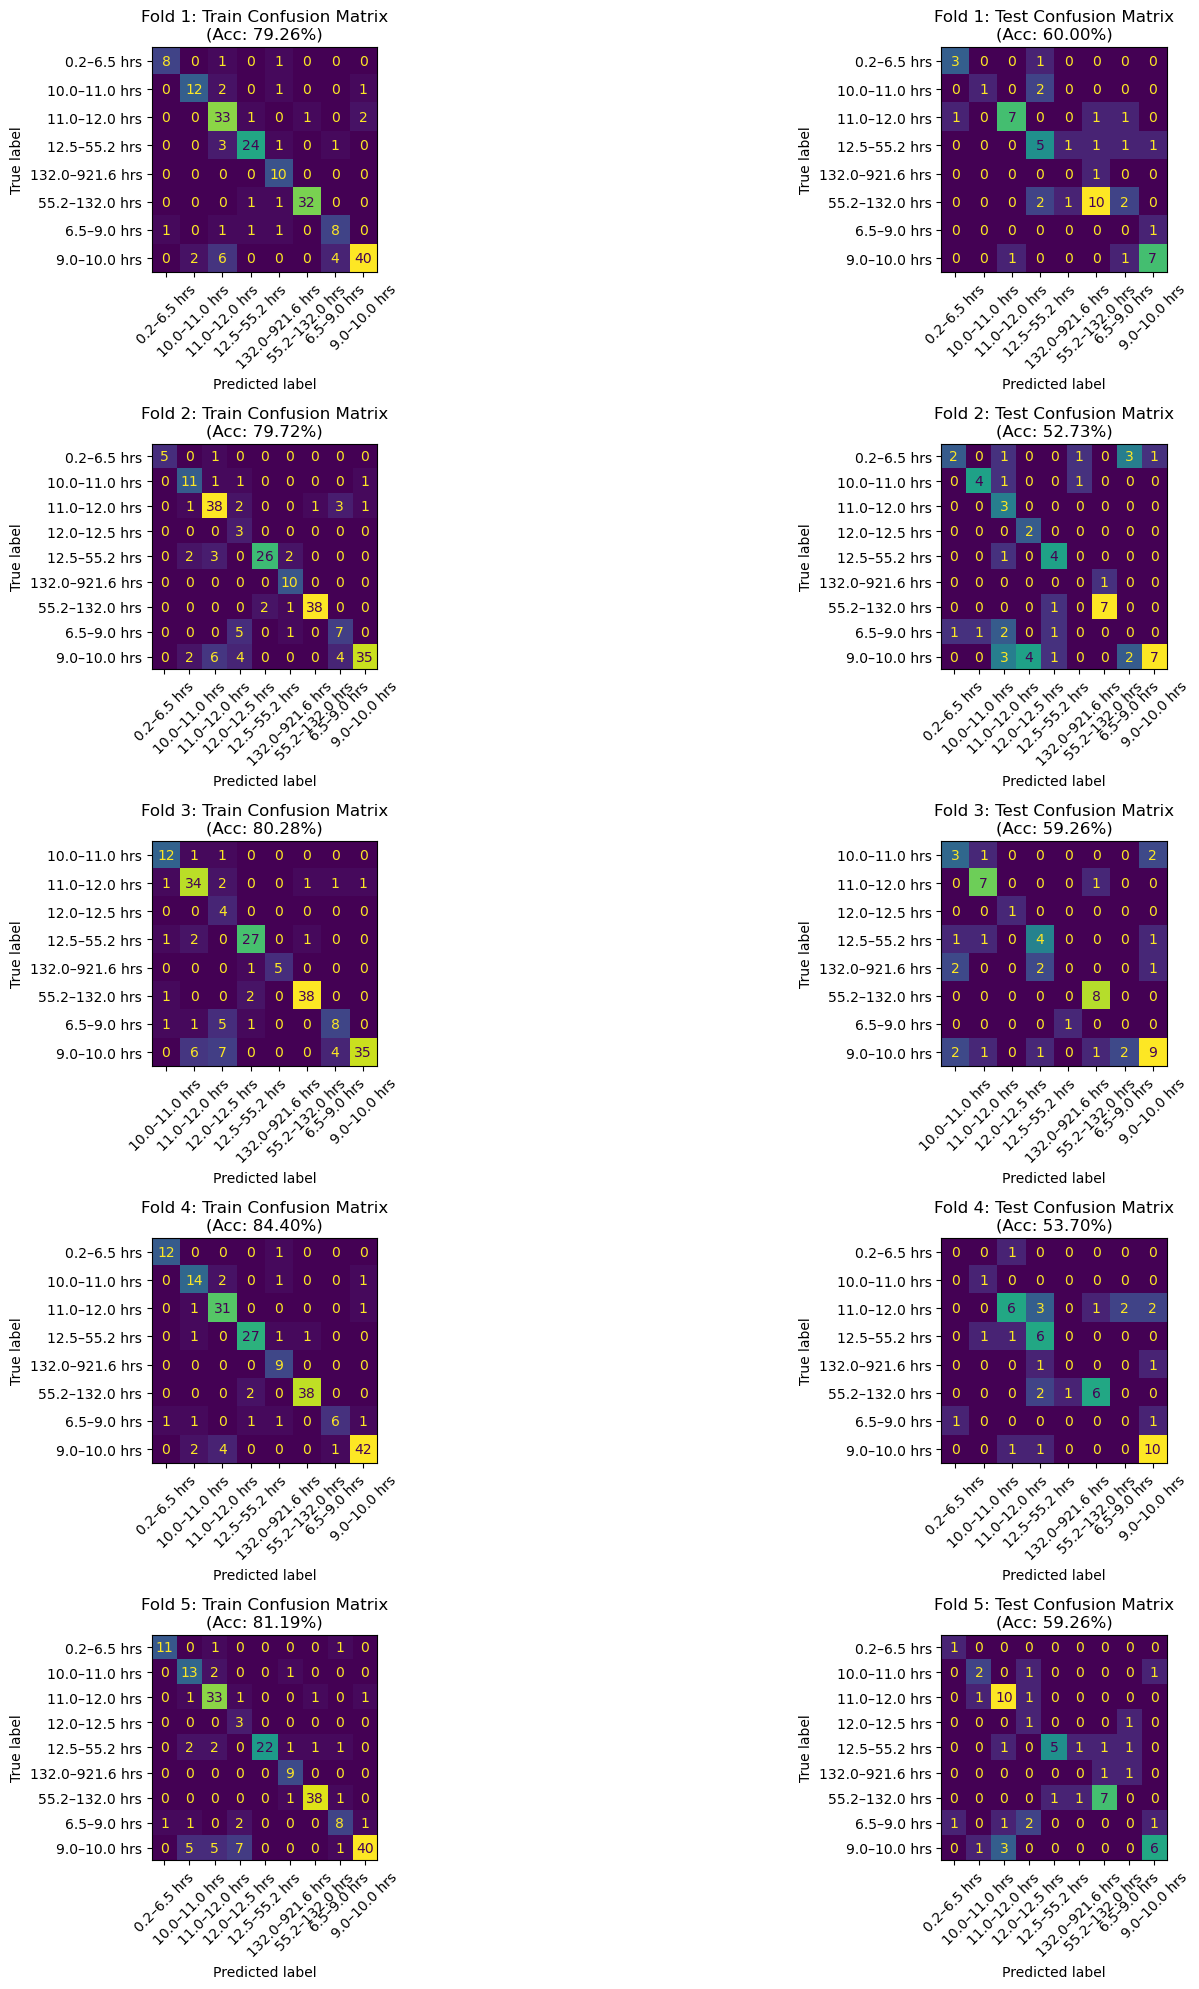


Detailed Results by Fold:
   fold  train_acc  test_acc  test_precision  test_recall  test_f1
0     1     0.7926    0.6000          0.7153       0.6000   0.6442
1     2     0.7972    0.5273          0.6609       0.5273   0.5348
2     3     0.8028    0.5926          0.5746       0.5926   0.5786
3     4     0.8440    0.5370          0.5909       0.5370   0.5461
4     5     0.8119    0.5926          0.6093       0.5926   0.5888

Average Metrics:
test_acc          0.5699
test_precision    0.6302
test_recall       0.5699
test_f1           0.5785
dtype: float64

Completed analysis for region 'NSW'


SUMMARY OF REGION-SPECIFIC MODELS
  Region  Samples   CV         Accuracy         F1 Score
0     SA      286  Yes  0.6402 ± 0.0782  0.6409 ± 0.0829
1    VIC     1251  Yes  0.3677 ± 0.0251  0.3809 ± 0.0361
2    TAS      145  Yes  0.6897 ± 0.0218  0.6831 ± 0.0348
3    QLD      376  Yes  0.6329 ± 0.0406  0.6414 ± 0.0415
4    NSW      272  Yes  0.5699 ± 0.0311  0.5785 ± 0.0384

Comparing top 3 featur

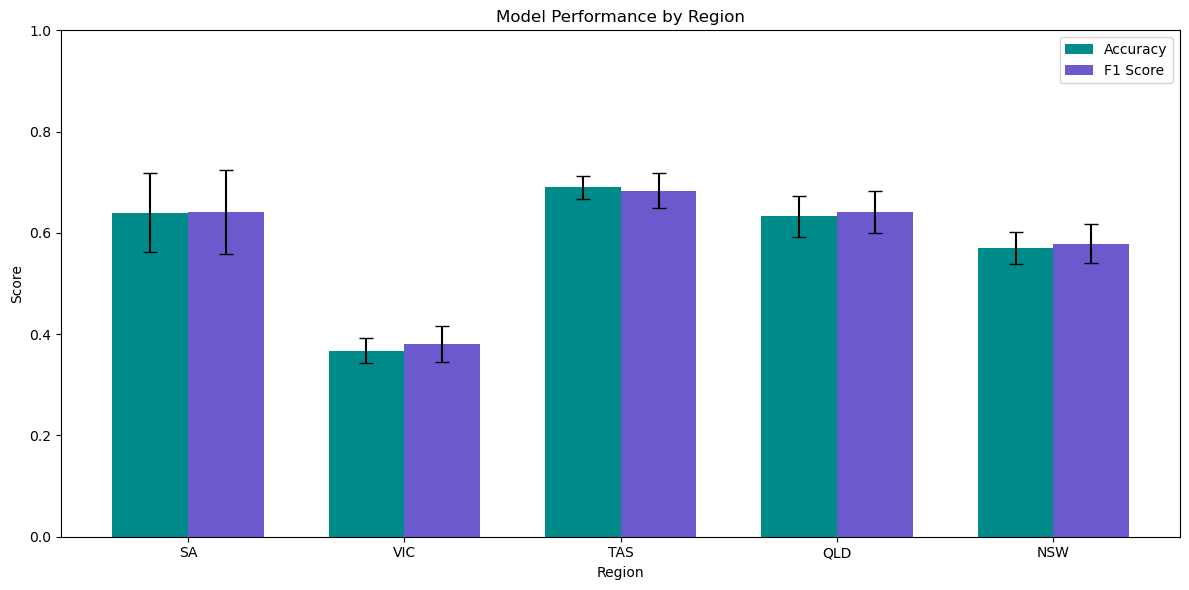

In [9]:
# Updated region-specific training with cross-validation
region_models = {}
region_cv_results = {}
region_fold_details = {}

# Loop through each unique region
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    print(f"\n{'='*50}")
    print(f"--- REGION: {region} (n={region_df.shape[0]} samples) ---")
    print(f"{'='*50}")
    
    # Check if we have enough samples for cross-validation
    if region_df.shape[0] < 10:  # Arbitrary minimum, adjust as needed
        print(f"⚠️ Region '{region}' has only {region_df.shape[0]} samples - skipping cross-validation")
        # Create a simple model without cross-validation
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.preprocessing import LabelEncoder
        
        # Select features and target (same as in other functions)
        features = ['Recall_Day_Hours', 'Recall_Night_Hours',
                    'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',
                    'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']
        target = 'Duration_Category'
        
        X = region_df[features].copy()
        y = region_df[target]
        
        # Encode categorical features
        for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
            X[col] = LabelEncoder().fit_transform(X[col])
        
        # Train a simple model on all data
        model = RandomForestClassifier(random_state=42, class_weight='balanced')
        model.fit(X, y)
        
        print(f"Trained a simple model on all {region_df.shape[0]} samples (no CV)")
        
        region_models[region] = model
        continue
    
    # 1. Run cross-validation and get overall metrics
    print(f"\nRunning cross-validation for region '{region}':")
    model, cv_results = train_with_cross_validation(region_df, n_folds=5)
    region_models[region] = model
    region_cv_results[region] = cv_results
    
    # 2. Run detailed fold analysis for this region
    print(f"\nDetailed fold analysis for region '{region}':")
    fold_results = detailed_fold_analysis(region_df, n_folds=5)
    region_fold_details[region] = fold_results
    
    print(f"\nCompleted analysis for region '{region}'")

# Print summary of all regions
print("\n")
print("="*80)
print("SUMMARY OF REGION-SPECIFIC MODELS")
print("="*80)

# Create a summary table of results
import pandas as pd
import numpy as np

summary_data = []
for region in region_models.keys():
    if region in region_cv_results:
        # For regions with CV results
        cv_res = region_cv_results[region]
        summary_data.append({
            'Region': region,
            'Samples': df[df['Region'] == region].shape[0],
            'CV': 'Yes',
            'Accuracy': f"{cv_res['test_accuracy'].mean():.4f} ± {cv_res['test_accuracy'].std():.4f}",
            'F1 Score': f"{cv_res['test_f1_weighted'].mean():.4f} ± {cv_res['test_f1_weighted'].std():.4f}"
        })
    else:
        # For regions without CV (fallback to train_test_split)
        summary_data.append({
            'Region': region,
            'Samples': df[df['Region'] == region].shape[0],
            'CV': 'No',
            'Accuracy': 'N/A',
            'F1 Score': 'N/A'
        })

# Print summary table
summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Compare feature importances across regions
print("\nComparing top 3 features by importance across regions:")
for region, model in region_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Get feature names (assuming they're the same across all regions)
        features = ['Recall_Day_Hours', 'Recall_Night_Hours', 
                   'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',
                   'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']
        
        top_features = [features[i] for i in indices[:3]]
        top_importance = importances[indices[:3]]
        
        print(f"{region}: {', '.join([f'{f} ({i:.4f})' for f, i in zip(top_features, top_importance)])}")

# Optional: Visualize comparison of accuracies across regions
import matplotlib.pyplot as plt

# Filter regions with CV results
cv_regions = [r for r in region_models.keys() if r in region_cv_results]

if len(cv_regions) >= 2:  # Only plot if we have at least 2 regions with CV
    plt.figure(figsize=(12, 6))
    
    # Extract data for plotting
    regions = cv_regions
    accuracies = [region_cv_results[r]['test_accuracy'].mean() for r in regions]
    acc_stds = [region_cv_results[r]['test_accuracy'].std() for r in regions]
    f1_scores = [region_cv_results[r]['test_f1_weighted'].mean() for r in regions]
    f1_stds = [region_cv_results[r]['test_f1_weighted'].std() for r in regions]
    
    # Plot
    x = np.arange(len(regions))
    width = 0.35
    
    plt.bar(x - width/2, accuracies, width, label='Accuracy', 
           color='darkcyan', yerr=acc_stds, capsize=5)
    plt.bar(x + width/2, f1_scores, width, label='F1 Score',
           color='slateblue', yerr=f1_stds, capsize=5)
    
    plt.title('Model Performance by Region')
    plt.xlabel('Region')
    plt.ylabel('Score')
    plt.xticks(x, regions)
    plt.legend()
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()